# Exploratory Data Analysis of O2C Order Data

This notebook conducts an exploratory data analysis (EDA) on the `o2c_data_orders_only.xml` dataset. The goal is to understand the structure of the Order-to-Cash process, identify common patterns, and extract key performance indicators.

We will answer the following questions:
1. What does a sample of the data look like?
2. How many total orders are in the dataset?
3. What are the different types of events, and what is their typical order of execution?
4. How many unique process variants exist in the data?
5. What does a common process variant look like?
6. What is the average execution time for each event?
7. What is the average total execution time for an order?
8. What is the distribution of order completion times?


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from collections import Counter

# Define the path to the dataset
DATA_FILE = '../data/o2c_data_orders_only.xml'

def parse_case_centric_log(file_path):
    """
    Parse the case-centric event log XML file.
    Each <trace> represents one order with its attributes and events.
    """
    print("Parsing case-centric event log...")
    
    all_events = []
    all_orders = []
    
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    for trace in root.findall('trace'):
        # Extract order attributes
        order_id = None
        order_value = None
        order_status = None
        
        for string_elem in trace.findall('string'):
            key = string_elem.get('key')
            value = string_elem.get('value')
            
            if key == 'concept:name':
                order_id = value
            elif key == 'order_value':
                order_value = float(value) if value else 0.0
            elif key == 'order_status':
                order_status = value
        
        # Store order information
        all_orders.append({
            'order_id': order_id,
            'order_value': order_value,
            'order_status': order_status
        })
        
        # Extract events for this order
        events = trace.findall('event')
        for event in events:
            event_name = None
            event_time = None
            
            for child in event:
                if child.get('key') == 'concept:name':
                    event_name = child.get('value')
                elif child.get('key') == 'time:timestamp':
                    event_time = child.get('value')
            
            if event_name and event_time:
                all_events.append({
                    'order_id': order_id,
                    'event_name': event_name,
                    'timestamp': datetime.fromisoformat(event_time.replace('Z', '+00:00')),
                    'order_value': order_value,
                    'order_status': order_status
                })
    
    print(f"Parsing complete. Found {len(all_orders)} orders and {len(all_events)} events.")
    
    return pd.DataFrame(all_events), pd.DataFrame(all_orders)

# Load the data
df_events, df_orders = parse_case_centric_log(DATA_FILE)

# Sort events by order and timestamp
if not df_events.empty:
    df_events = df_events.sort_values(by=['order_id', 'timestamp']).reset_index(drop=True)
    print("Data loading complete. DataFrames `df_events` and `df_orders` are now available.")
else:
    print("Could not load data. The DataFrames are empty.")


Parsing case-centric event log...
Parsing complete. Found 2000 orders and 19371 events.
Data loading complete. DataFrames `df_events` and `df_orders` are now available.


## 1. Sample from the Data

Let's start by looking at a sample of the data to understand its structure. We'll display the first 10 entries from our parsed DataFrame.


In [3]:
# Display sample of orders
print("=" * 80)
print("SAMPLE ORDERS")
print("=" * 80)
print(df_orders.head(10))
print("\n" + "=" * 80)
print("SAMPLE EVENTS (First 20)")
print("=" * 80)
print(df_events.head(20))


SAMPLE ORDERS
   order_id  order_value order_status
0   order_1          0.0     Approved
1   order_2          0.0     Approved
2   order_3          0.0     Approved
3   order_4          0.0     Approved
4   order_5          0.0     Approved
5   order_6          0.0     Approved
6   order_7          0.0     Approved
7   order_8          0.0     Approved
8   order_9          0.0     Approved
9  order_10          0.0     Approved

SAMPLE EVENTS (First 20)
    order_id                  event_name                  timestamp  \
0    order_1      Receive Customer Order 2024-10-02 07:55:15.348555   
1    order_1     Validate Customer Order 2024-10-02 07:56:15.348555   
2    order_1        Perform Credit Check 2024-10-02 07:57:15.348555   
3    order_1               Approve Order 2024-10-02 07:58:15.348555   
4    order_1  Schedule Order Fulfillment 2024-10-02 07:59:15.348555   
5    order_1          Generate Pick List 2024-10-02 08:00:15.348555   
6    order_1                  Pack Items 2024

## 2. Total Number of Orders

Next, let's determine the total number of unique orders in the dataset. This gives us the overall sample size of our process analysis.


In [4]:
total_orders = len(df_orders)
total_events = len(df_events)
avg_events_per_order = total_events / total_orders if total_orders > 0 else 0

print(f"📊 Dataset Summary:")
print(f"  - Total Orders: {total_orders}")
print(f"  - Total Events: {total_events}")
print(f"  - Average Events per Order: {avg_events_per_order:.2f}")


📊 Dataset Summary:
  - Total Orders: 2000
  - Total Events: 19371
  - Average Events per Order: 9.69


## 3. Event Types and Execution Order

Here, we will identify all the unique events (activities) that occur in the process. We will also determine the most common sequence of these events to understand the "main path" of the process.


In [5]:
if not df_events.empty:
    # Get the list of unique event types
    event_types = df_events['event_name'].unique()
    print(f"📋 There are {len(event_types)} unique event types in the dataset:\n")
    for i, event in enumerate(sorted(event_types), 1):
        print(f"{i:2d}. {event}")

    # Get event frequency
    print("\n" + "=" * 80)
    print("EVENT FREQUENCY")
    print("=" * 80)
    event_counts = df_events['event_name'].value_counts()
    print(event_counts.to_string())

    # To find the most common order of execution, we can analyze the sequence of events for each order
    # This sequence is also known as a "process variant"
    process_variants = df_events.groupby('order_id')['event_name'].apply(lambda x: ' → '.join(x))
    
    if not process_variants.empty:
        most_common_variant = process_variants.mode()[0]
        variant_count = (process_variants == most_common_variant).sum()
        print(f"\n{'=' * 80}")
        print(f"MOST COMMON ORDER OF EXECUTION (appears {variant_count} times):")
        print("=" * 80)
        print(most_common_variant.replace(' → ', '\n → '))
    else:
        print("\n\nCould not determine the most common order of execution as no process variants were found.")
else:
    print("DataFrame is empty. Cannot analyze event types.")


📋 There are 13 unique event types in the dataset:

 1. Apply Discount
 2. Approve Order
 3. Generate Invoice
 4. Generate Pick List
 5. Generate Shipping Label
 6. Pack Items
 7. Perform Credit Check
 8. Process Return Request
 9. Receive Customer Order
10. Reject Order
11. Schedule Order Fulfillment
12. Ship Order
13. Validate Customer Order

EVENT FREQUENCY
event_name
Receive Customer Order        2000
Validate Customer Order       2000
Perform Credit Check          2000
Approve Order                 1809
Schedule Order Fulfillment    1809
Generate Pick List            1809
Pack Items                    1809
Generate Shipping Label       1809
Ship Order                    1809
Generate Invoice              1809
Apply Discount                 414
Reject Order                   191
Process Return Request         103

MOST COMMON ORDER OF EXECUTION (appears 1347 times):
Receive Customer Order
 → Validate Customer Order
 → Perform Credit Check
 → Approve Order
 → Schedule Order Fulfillme

## 4. Analysis of Process Variants

A "process variant" is a unique sequence of events from start to finish. Analyzing variants helps us understand how much the process deviates from the main path. A high number of variants can indicate complexity, exceptions, or inefficiencies.


🔄 There are 8 unique process variants in the dataset.
   This means there are 8 different ways orders flow through the process.

TOP 10 MOST COMMON PROCESS VARIANTS

Variant 1 (1347 orders, 67.3%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Approve Order → Schedule O...

Variant 2 (365 orders, 18.2%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Approve Order → Schedule O...

Variant 3 (151 orders, 7.5%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Reject Order

Variant 4 (84 orders, 4.2%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Approve Order → Schedule O...

Variant 5 (34 orders, 1.7%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Reject Order → Apply Disco...

Variant 6 (13 orders, 0.7%):
  Receive Customer Order → Validate Customer Order → Perform Credit Check → Approve Order → Schedule O...

Variant 7 (4 orders, 0.2%):
 

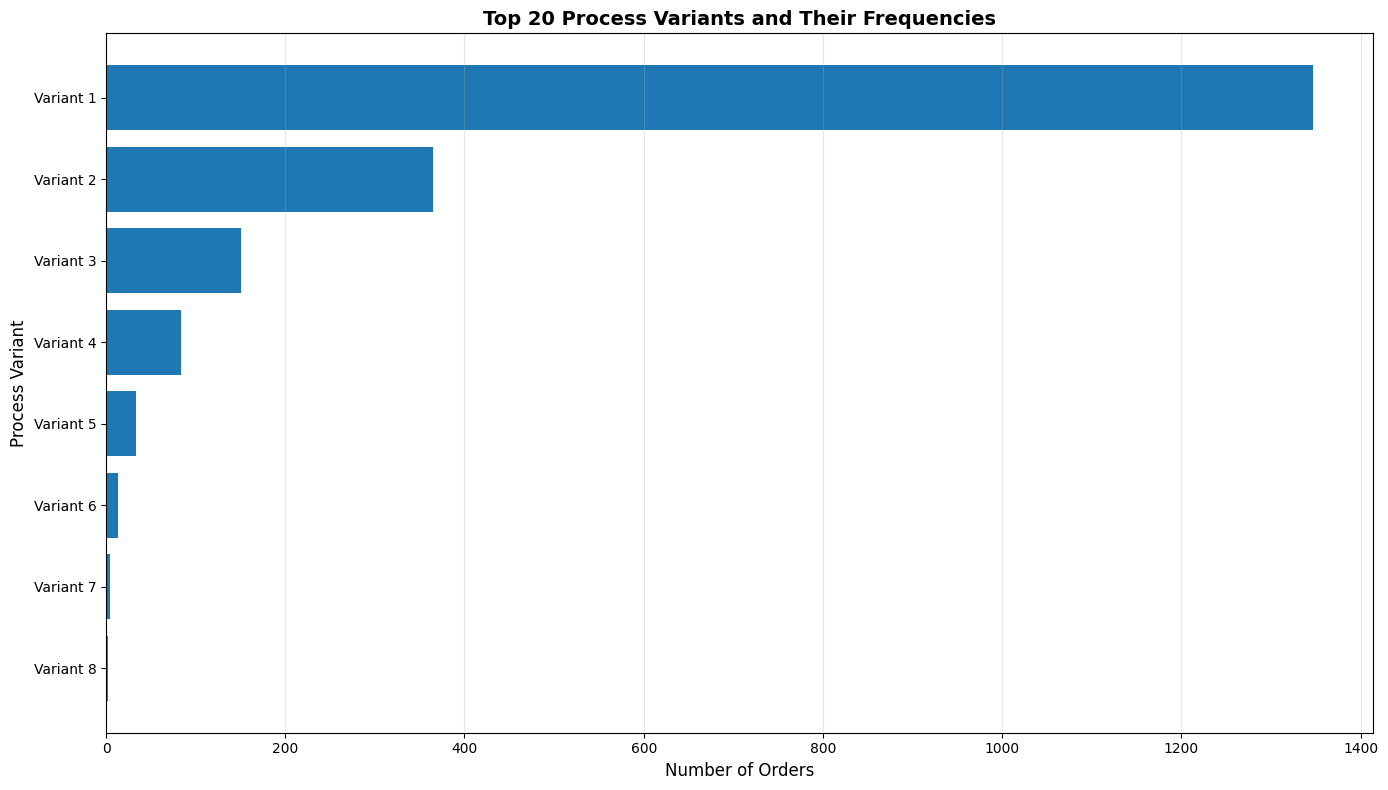

In [6]:
if not df_events.empty:
    # We already calculated the process variants in the previous step
    variant_counts = process_variants.value_counts()
    total_variants = len(variant_counts)

    print(f"🔄 There are {total_variants} unique process variants in the dataset.")
    print(f"   This means there are {total_variants} different ways orders flow through the process.\n")

    # Display the top 10 most common variants and their frequencies
    print("=" * 80)
    print("TOP 10 MOST COMMON PROCESS VARIANTS")
    print("=" * 80)
    for i, (variant, count) in enumerate(variant_counts.head(10).items(), 1):
        percentage = (count / total_orders) * 100
        print(f"\nVariant {i} ({count} orders, {percentage:.1f}%):")
        print(f"  {variant[:100]}{'...' if len(variant) > 100 else ''}")

    # Plot the distribution of variants
    plt.figure(figsize=(14, 8))
    top_20 = variant_counts.head(20)
    plt.barh(range(len(top_20)), top_20.values)
    plt.yticks(range(len(top_20)), [f"Variant {i+1}" for i in range(len(top_20))])
    plt.title('Top 20 Process Variants and Their Frequencies', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Orders', fontsize=12)
    plt.ylabel('Process Variant', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty. Cannot analyze process variants.")


## 5. Example of a Process Variant

Let's take a closer look at the most common process variant. This represents the "happy path" - the sequence of events that most orders follow.


In [7]:
if not df_events.empty and 'most_common_variant' in locals():
    print("=" * 80)
    print("DETAILED VIEW: MOST COMMON PROCESS VARIANT")
    print("=" * 80)
    # Split the variant string for better readability
    events_in_variant = most_common_variant.split(' → ')
    for i, event in enumerate(events_in_variant, 1):
        print(f"  Step {i:2d}: {event}")
    
    print(f"\n📊 This variant appears in {variant_count} out of {total_orders} orders ({variant_count/total_orders*100:.1f}%)")
else:
    print("Cannot display an example variant as no variants were found.")


DETAILED VIEW: MOST COMMON PROCESS VARIANT
  Step  1: Receive Customer Order
  Step  2: Validate Customer Order
  Step  3: Perform Credit Check
  Step  4: Approve Order
  Step  5: Schedule Order Fulfillment
  Step  6: Generate Pick List
  Step  7: Pack Items
  Step  8: Generate Shipping Label
  Step  9: Ship Order
  Step 10: Generate Invoice

📊 This variant appears in 1347 out of 2000 orders (67.3%)


## 6. Analysis of Event Execution Time

Now, we'll analyze the time it takes to transition from one event to the next. This helps us identify potential bottlenecks in the process. We define "event execution time" as the duration between the start of one event and the start of the next.


AVERAGE EVENT EXECUTION TIME (in hours)
Process Return Request                   : 668.33 hours (27.85 days)
Apply Discount                           : 178.49 hours ( 7.44 days)
Generate Invoice                         :   0.03 hours ( 0.00 days)
Pack Items                               :   0.03 hours ( 0.00 days)
Approve Order                            :   0.02 hours ( 0.00 days)
Generate Pick List                       :   0.02 hours ( 0.00 days)
Generate Shipping Label                  :   0.02 hours ( 0.00 days)
Perform Credit Check                     :   0.02 hours ( 0.00 days)
Reject Order                             :   0.02 hours ( 0.00 days)
Schedule Order Fulfillment               :   0.02 hours ( 0.00 days)
Ship Order                               :   0.02 hours ( 0.00 days)
Validate Customer Order                  :   0.02 hours ( 0.00 days)
Receive Customer Order                   :    nan hours (  nan days)


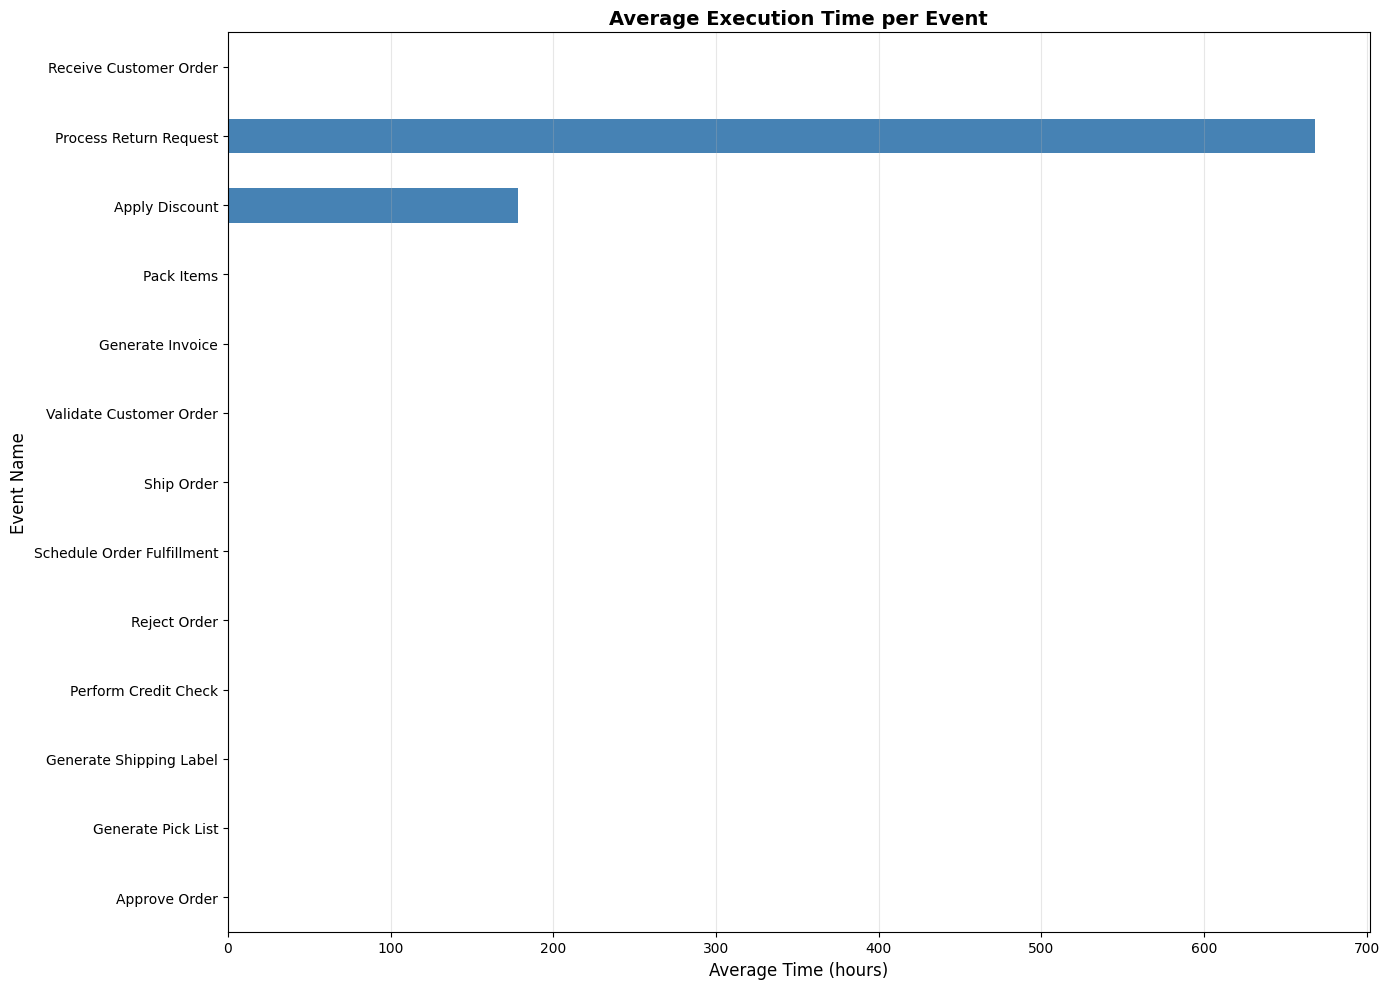


📊 Summary Statistics:
  - Longest average event time: 668.33 hours (Process Return Request)
  - Shortest average event time: 0.02 hours (Approve Order)


In [8]:
if not df_events.empty:
    # Calculate the time difference between consecutive events for each order
    df_events['time_diff'] = df_events.groupby('order_id')['timestamp'].diff().dt.total_seconds() / 3600  # in hours

    # Calculate the average execution time for each event
    avg_event_time = df_events.groupby('event_name')['time_diff'].mean().sort_values(ascending=False)

    print("=" * 80)
    print("AVERAGE EVENT EXECUTION TIME (in hours)")
    print("=" * 80)
    for event, time_hrs in avg_event_time.items():
        print(f"{event:40s} : {time_hrs:6.2f} hours ({time_hrs/24:5.2f} days)")

    # Visualize the average execution times
    plt.figure(figsize=(14, 10))
    avg_event_time.sort_values().plot(kind='barh', color='steelblue')
    plt.title('Average Execution Time per Event', fontsize=14, fontweight='bold')
    plt.xlabel('Average Time (hours)', fontsize=12)
    plt.ylabel('Event Name', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Summary Statistics:")
    print(f"  - Longest average event time: {avg_event_time.max():.2f} hours ({avg_event_time.idxmax()})")
    print(f"  - Shortest average event time: {avg_event_time.min():.2f} hours ({avg_event_time.idxmin()})")
else:
    print("DataFrame is empty. Cannot analyze event execution times.")


## 7. Average Execution Time for an Order

Let's calculate the average total time it takes to process an order from the very first event to the very last. This is also known as the "case duration" or "cycle time".


ORDER EXECUTION TIME ANALYSIS
Average execution time: 71.54 hours (2.98 days)
Median execution time:  0.18 hours (0.01 days)
Minimum execution time: 0.05 hours (0.00 days)
Maximum execution time: 840.28 hours (35.01 days)
Standard deviation:     167.02 hours


/Users/u.srinivasan/Documents/Projects_Garage/Process_Simulation_unseen_variant/backend/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/u.srinivasan/Documents/Projects_Garage/Process_Simulation_unseen_variant/backend/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/u.srinivasan/Documents/Projects_Garage/Process_Simulation_unseen_variant/backend/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


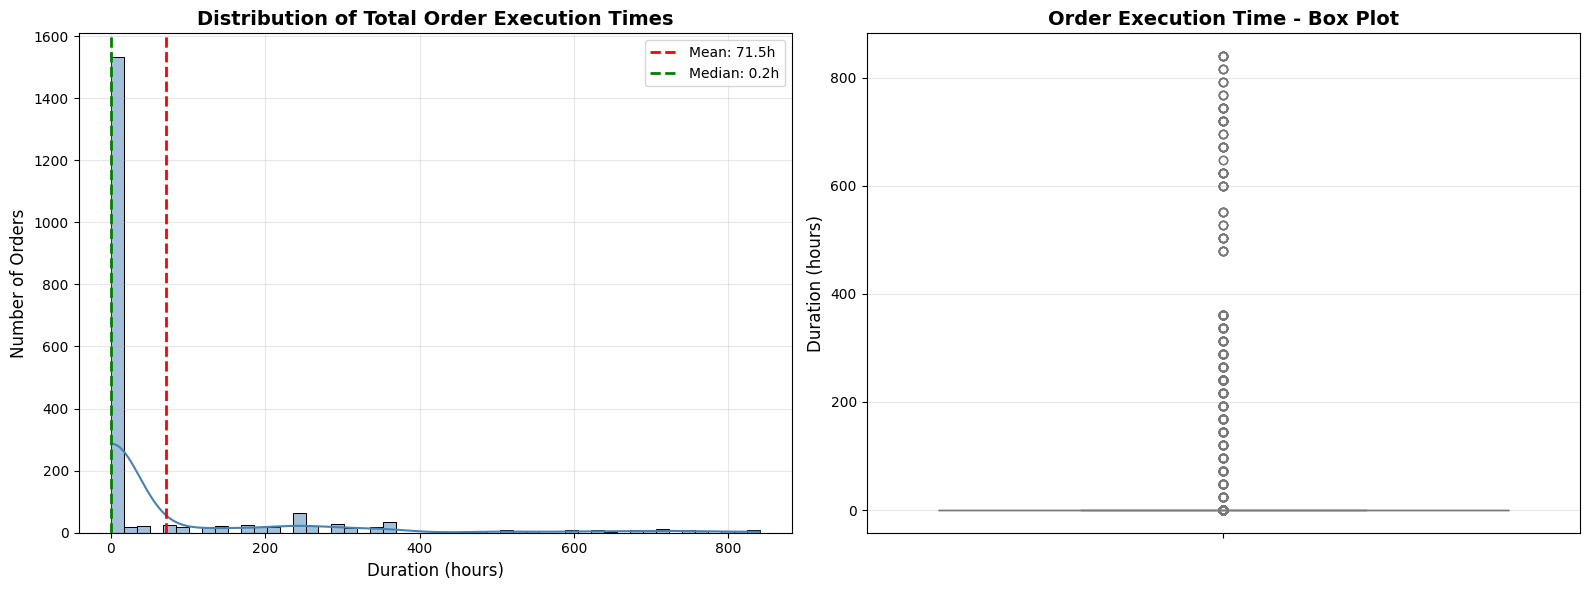

In [9]:
if not df_events.empty:
    # Calculate the total duration for each order
    order_durations = df_events.groupby('order_id')['timestamp'].agg(['min', 'max'])
    order_durations['duration_hours'] = (order_durations['max'] - order_durations['min']).dt.total_seconds() / 3600
    order_durations['duration_days'] = order_durations['duration_hours'] / 24

    # Calculate statistics
    avg_order_time = order_durations['duration_hours'].mean()
    median_order_time = order_durations['duration_hours'].median()
    min_order_time = order_durations['duration_hours'].min()
    max_order_time = order_durations['duration_hours'].max()

    print("=" * 80)
    print("ORDER EXECUTION TIME ANALYSIS")
    print("=" * 80)
    print(f"Average execution time: {avg_order_time:.2f} hours ({avg_order_time/24:.2f} days)")
    print(f"Median execution time:  {median_order_time:.2f} hours ({median_order_time/24:.2f} days)")
    print(f"Minimum execution time: {min_order_time:.2f} hours ({min_order_time/24:.2f} days)")
    print(f"Maximum execution time: {max_order_time:.2f} hours ({max_order_time/24:.2f} days)")
    print(f"Standard deviation:     {order_durations['duration_hours'].std():.2f} hours")

    # Plot the distribution of order durations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram with KDE
    sns.histplot(order_durations['duration_hours'], bins=50, kde=True, ax=axes[0], color='steelblue')
    axes[0].axvline(avg_order_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_order_time:.1f}h')
    axes[0].axvline(median_order_time, color='green', linestyle='--', linewidth=2, label=f'Median: {median_order_time:.1f}h')
    axes[0].set_title('Distribution of Total Order Execution Times', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Duration (hours)', fontsize=12)
    axes[0].set_ylabel('Number of Orders', fontsize=12)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    sns.boxplot(y=order_durations['duration_hours'], ax=axes[1], color='lightblue')
    axes[1].set_title('Order Execution Time - Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Duration (hours)', fontsize=12)
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty. Cannot analyze order execution times.")
